## Part1. Generating the dataset

In [1]:
from sklearn.datasets import make_classification
import pandas as pd
import numpy as np

X, y = make_classification(n_samples = 10000, n_features = 20, n_informative = 12, n_classes = 4)
y = pd.Series(y).map({0: 'A', 1: 'B', 2: 'C', 3: 'D'})

In [3]:
X

array([[-2.65831948,  1.169739  ,  1.2127    , ...,  0.16924386,
        -0.22537888,  1.4220368 ],
       [ 1.60906611,  0.94985136, -0.01360925, ...,  0.47346334,
        -2.14764938,  2.63069039],
       [-0.94151586, -0.59466756,  0.75575836, ...,  0.82579998,
         1.43484284, -1.4514795 ],
       ...,
       [ 0.86148249,  0.37863842, -0.25584826, ...,  2.25894864,
        -3.5113316 , -2.88703605],
       [-1.63330888, -1.74562753,  1.58063076, ..., -1.53239907,
         2.9187432 ,  0.06328621],
       [-2.2144845 , -1.31543517, -0.96859032, ...,  0.31136024,
         0.81867325,  4.4217627 ]])

In [4]:
y

0       C
1       D
2       B
3       A
4       C
       ..
9995    A
9996    A
9997    A
9998    C
9999    C
Length: 10000, dtype: object

In [2]:
# split the data into training and testing set using stratified sampling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 42)

## Part2. Building the basic ordinal classification model

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from ModelingTools.CustomModel.ordinal import OrdinalClassifier

base_clf = DecisionTreeClassifier(min_samples_leaf = 2) # use decision tree as the base estimator in the ordinal classification world
odc = OrdinalClassifier(estimator = base_clf, ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1) # n_jobs = -1 enables parallel training, ordered_classes specify ordered target var

In [6]:
odc.fit(X_train, y_train) # train the model

OrdinalClassifier(estimator=DecisionTreeClassifier(min_samples_leaf=2),
                  ordered_classes=array(['A', 'B', 'C', 'D'], dtype='<U1'))

In [7]:
# make prediction
odc.predict(X_test)

array(['B', 'B', 'B', ..., 'B', 'B', 'B'], dtype=object)

In [8]:
# also support probability prediction following sklearn design
odc.predict_proba(X_test)

array([[0.1469628 , 0.3994863 , 0.05406459, 0.3994863 ],
       [0.1748777 , 0.47536689, 0.1748777 , 0.1748777 ],
       [0.1748777 , 0.47536689, 0.1748777 , 0.1748777 ],
       ...,
       [0.1748777 , 0.47536689, 0.1748777 , 0.1748777 ],
       [0.1469628 , 0.3994863 , 0.05406459, 0.3994863 ],
       [0.1748777 , 0.47536689, 0.1748777 , 0.1748777 ]])

In [9]:
# aLso support decision function
odc.decision_function(X_test)

array([[ 0.,  1., -1.,  1.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       ...,
       [ 0.,  1.,  0.,  0.],
       [ 0.,  1., -1.,  1.],
       [ 0.,  1.,  0.,  0.]])

#### evaluate the model using regular classification model metric

In [20]:
from ModelingTools.Evaluation import ClfValidator

clv = ClfValidator(odc, X_test, y_test)

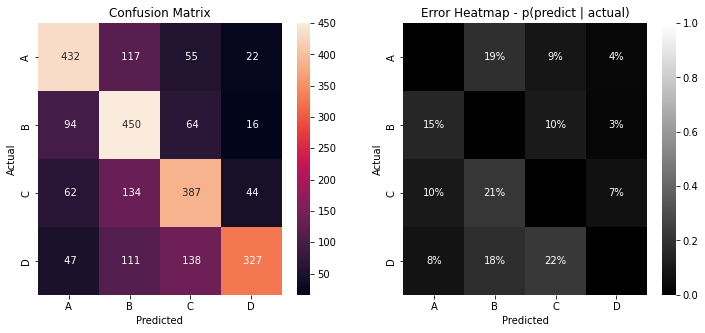

In [21]:
cm = clv.confusion_matrix()

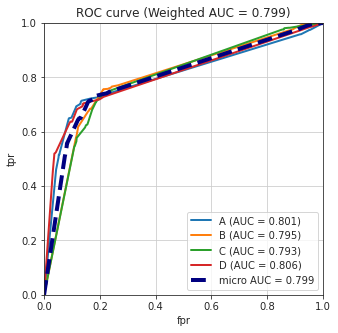

In [22]:
rocs = clv.roc_curve(average = 'micro')

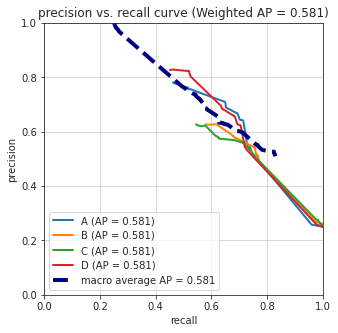

In [23]:
precs = clv.precision_recall()

#### evaluate the model using ordinal classification metric

In [41]:
from ModelingTools.Evaluation import OrdinalClfValidator

ocv = OrdinalClfValidator(odc, X_test, y_test, ordered_classes = ['A', 'B', 'C', 'D'])

In [42]:
ocv.conf_mat(error = False)

array([[432, 117,  55,  22],
       [ 94, 450,  64,  16],
       [ 62, 134, 387,  44],
       [ 47, 111, 138, 327]])

actual    A    B    C    D
Exact   432  450  387  327
w/i ±1  549  608  565  465
w/i ±2  604  624  627  576
w/i ±3  626  624  627  623

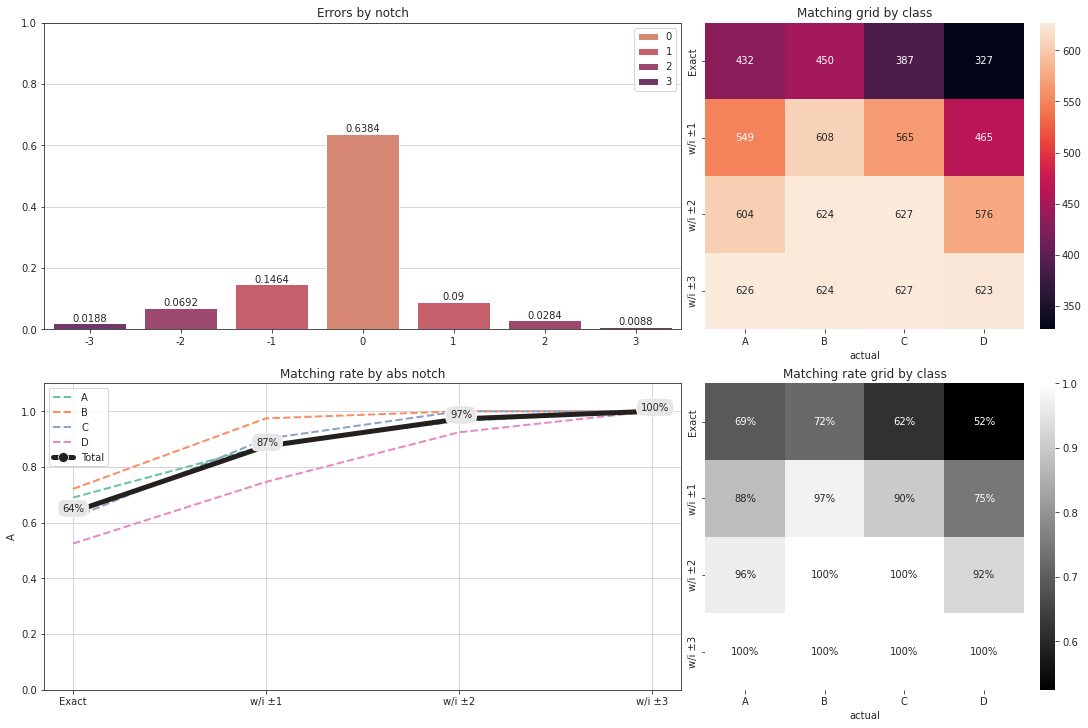

In [43]:
ocv.rank_matching(rate = False, plot = True)

## Part3. Building the advanced ordinal classification model

In [11]:
from sklearn.ensemble import RandomForestClassifier
from ModelingTools.CustomModel.ordinal import OrdinalClassifierPlus

odcp = OrdinalClassifierPlus(estimator = RandomForestClassifier(n_jobs = -1), output_layer = 'softmax', ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1) # specify the output activation layer as softmax

In [13]:
odcp.fit(X_train, y_train)

OrdinalClassifierPlus(estimator=RandomForestClassifier(n_jobs=-1),
                      ordered_classes=array(['A', 'B', 'C', 'D'], dtype='<U1'))

In [14]:
odcp.predict(X_test)

array(['B', 'B', 'B', ..., 'A', 'D', 'B'], dtype='<U1')

In [15]:
# check score (kendall tau correlation)
odcp.score(X_test, y_test)

0.7727866836544889

#### evaluate the model using regular classification model metric

In [24]:
from ModelingTools.Evaluation import ClfValidator

clv = ClfValidator(odcp, X_test, y_test)

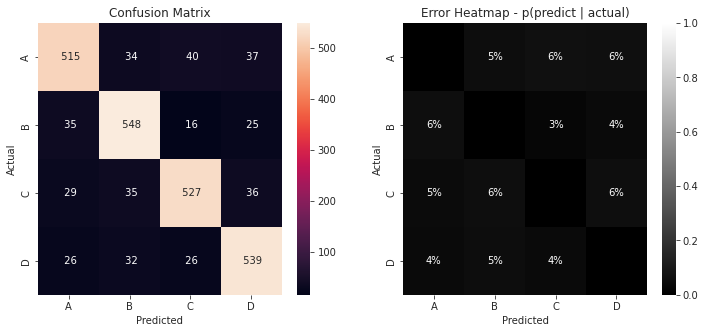

In [25]:
cm = clv.confusion_matrix()

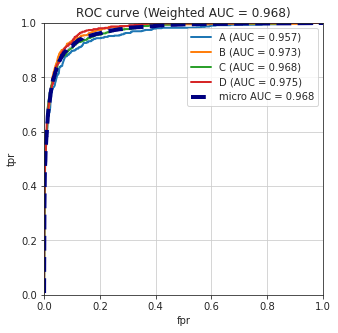

In [26]:
rocs = clv.roc_curve(average = 'micro')

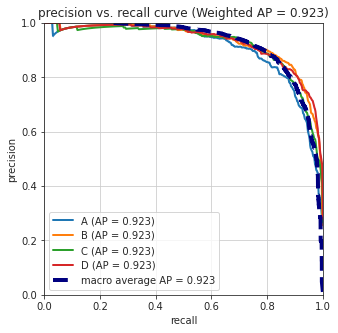

In [27]:
precs = clv.precision_recall()

#### evaluate the model using ordinal classification metric

In [38]:
from ModelingTools.Evaluation import OrdinalClfValidator

ocv = OrdinalClfValidator(odcp, X_test, y_test, ordered_classes = ['A', 'B', 'C', 'D'])

In [39]:
ocv.conf_mat(error = False)

array([[515,  34,  40,  37],
       [ 35, 548,  16,  25],
       [ 29,  35, 527,  36],
       [ 26,  32,  26, 539]])

actual    A    B    C    D
Exact   515  548  527  539
w/i ±1  549  599  598  565
w/i ±2  589  624  627  597
w/i ±3  626  624  627  623

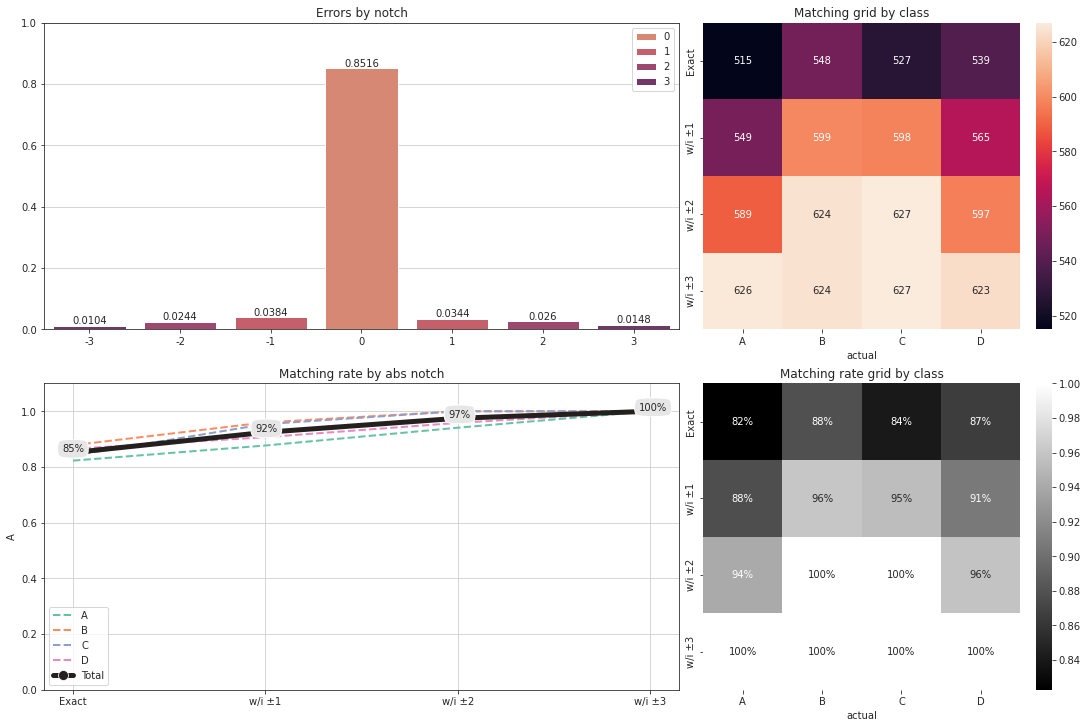

In [40]:
ocv.rank_matching(rate = False, plot = True)

## Part4. Compare different ordinal classification models

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

baseline_clf = RandomForestClassifier()  # use normal logistic regression as a baseline model
# see how ordinal framework helps the performance
base_clf = OrdinalClassifier(estimator = RandomForestClassifier(), ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1) # use normal version ordinal classifier
# see how the second layer affects the model performance
compare_clf1 = OrdinalClassifierPlus(estimator = RandomForestClassifier(), output_layer = 'softmax', ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1)
compare_clf2 = OrdinalClassifierPlus(estimator = RandomForestClassifier(), output_layer = 'lda', ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1)
compare_clf3 = OrdinalClassifierPlus(estimator = RandomForestClassifier(), output_layer = 'qda', ordered_classes = ['A', 'B', 'C', 'D'], n_jobs = -1)

In [61]:
baseline_clf.fit(X_train, y_train)
base_clf.fit(X_train, y_train)
compare_clf1.fit(X_train, y_train)
compare_clf2.fit(X_train, y_train)
compare_clf3.fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


OrdinalClassifierPlus(estimator=RandomForestClassifier(),
                      ordered_classes=array(['A', 'B', 'C', 'D'], dtype='<U1'),
                      output_layer='qda')

#### model validation across all different models --look at regular classification metric

In [62]:
from ModelingTools.Evaluation import ClfModelSelector

clf_dict = {'RF' : baseline_clf, 'RF+ordinal' : base_clf, 'RF+ordinal(softmax)' : compare_clf1, 'RF+ordinal(lda)' : compare_clf2, 'RF+ordinal(qda)' : compare_clf3}
clfms = ClfModelSelector(clf_dict, X_test, y_test)

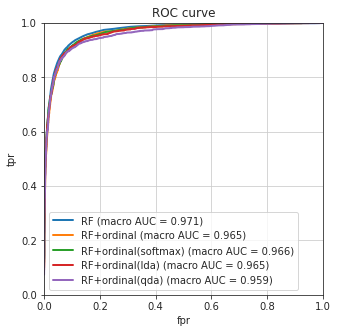

In [63]:
rocs = clfms.roc_curve(average = 'macro')

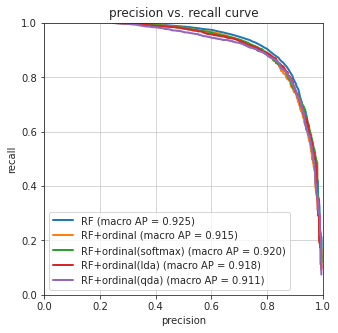

In [64]:
pre_recs = clfms.precision_recall(average = 'macro')

#### compare different models based on ordinal performance

In [65]:
from ModelingTools.Evaluation import OrdinalClfModelSelector

clf_dict = {'RF' : baseline_clf, 'RF+ordinal' : base_clf, 'RF+ordinal(softmax)' : compare_clf1, 'RF+ordinal(lda)' : compare_clf2, 'RF+ordinal(qda)' : compare_clf3}
ocms = OrdinalClfModelSelector(clf_dict, X_test, y_test, ordered_classes = ['A', 'B', 'C', 'D'])

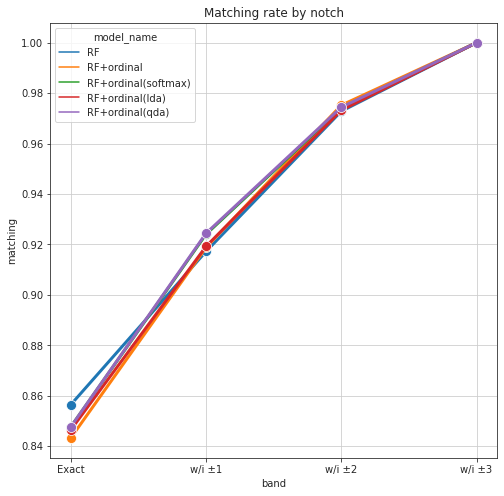

In [66]:
mr = ocms.rank_matching(by_class = None)

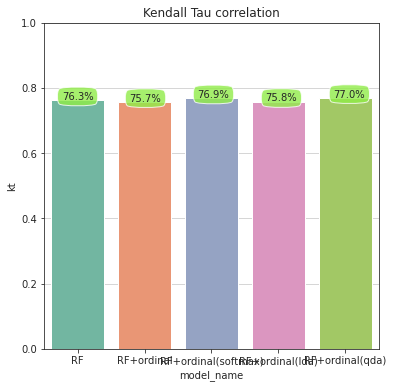

In [67]:
kt = ocms.kendall_tau()  # see rank order correlation